# Big Game, Big Data - Part 1: Understanding the Basics

### A Project by Noel McCann

<img src="Part_1_cover.jpg" style="width:640px;height:360px;">

**Purpose of Analysis:**  
As of January 22, only four teams remain in the NFL playoffs: the Baltimore Ravens, Detroit Lions,  Kansas City Chiefs, and San Francisco 49ers. As we've seen in the Wild Card and Divisional rounds, having a solid defense can make the difference between being a winning team in the regular season and an actual Super Bowl contender. For this and next week's project, we will delve deep into the 2022 season data to understand the defensive style for the final four and uncover insights into their players' performance. 

We hope that this analysis will provide fans and data scientists alike insights that could provide further appreciation for the defensive styles of these teams, as well as an understanding of which defensive unit will be most likely to reign supreme come the big game in Las Vegas.


## This project will:

- Use Numpy & Pandas packages to take a look into the basics of our data tables and assess tackle efficiency.
- Evaluate the Ravens, Lions, Chiefs and 49ers on their tackling proficiency and win rate.
- Look into the tackling performance for the four teams in the 4th quarter to see how these teams adapt to different schemes and in the clutch.


### Data Importing & Cleaning

Let's get started by getting our libraries set up. We'll first import everything we need to analyze the data.

In [102]:
import gc
import os
import numpy as np # linear algebra
import pandas as pd # data processing & CSV file previews (e.g. pd.read_csv)
import datetime as dt # for accurate times
import matplotlib.pyplot as plt # to create graphs
import matplotlib.cm as cm
import seaborn as sns
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

from colorama import Fore, Style, init
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

With everything we need to run our analysis, let's take a look into each of the base tables provided by the NFL for their 2024 Big Data Bowl competition on Kaggle.

In [103]:
games=pd.read_csv('games.csv')
players=pd.read_csv('players.csv')
tackles=pd.read_csv('tackles.csv')
plays=pd.read_csv('plays.csv')
tracking_1=pd.read_csv('tracking_week_1.csv')

### Data Outlines

we can derive various insights and metrics related to player performance, team performance, and game strategy. To do so, we will clean up our data to enable analyses that are more accurate and simpler to understand.

Let's first summarize the data frame feature to use common values.

In [104]:
def summarize_dataframe(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['missing#'] = df.isna().sum().values*100
    summary_df['missing%'] = (df.isna().sum().values*100)/len(df)
    summary_df['uniques'] = df.nunique().values
    summary_df['first_value'] = df.iloc[0].values
    summary_df['last_value'] = df.iloc[len(df)-1].values
    summary_df['count'] = df.count().values
    #sum['skew'] = df.skew().values
    desc = pd.DataFrame(df.describe().T)
    summary_df['min'] = desc['min']
    summary_df['max'] = desc['max']
    summary_df['mean'] = desc['mean']
    return summary_df

With that out of the way, let's look into our tables and understand the quality of data we are working with.

**1) Games**

In [105]:
games.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,09/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,09/11/2022,13:00:00,CAR,CLE,24,26
3,2022091102,2022,1,09/11/2022,13:00:00,CHI,SF,19,10
4,2022091103,2022,1,09/11/2022,13:00:00,CIN,PIT,20,23


The `games.csv` file contains the following columns:

1. **gameId**: The unique identifier for each game.
2. **season**: The year of the NFL season.
3. **week**: The week number within the NFL season.
4. **gameDate**: The date of the game.
5. **gameTimeEastern**: The start time of the game in Eastern Time.
6. **homeTeamAbbr**: The abbreviation of the home team.
7. **visitorTeamAbbr**: The abbreviation of the visiting team.
8. **homeFinalScore**: The final score of the home team.
9. **visitorFinalScore**: The final score of the visiting team.

Time to see if there are missing values or other data quality issues.

In [106]:
# Game table summary
summarize_dataframe(games).style.background_gradient(cmap='Greens')

,dtypes,missing#,missing%,uniques,first_value,last_value,count,min,max,mean
gameId,int64,0,0.000000,136,2022090800,2022110700,136,2022090800.000000,2022110700.000000,2022098922.117647
season,int64,0,0.000000,1,2022,2022,136,2022.000000,2022.000000,2022.000000
week,int64,0,0.000000,9,1,9,136,1.000000,9.000000,4.845588
gameDate,object,0,0.000000,27,09/08/2022,11/07/2022,136,nan,nan,nan
gameTimeEastern,object,0,0.000000,8,20:20:00,20:15:00,136,nan,nan,nan
homeTeamAbbr,object,0,0.000000,32,LA,NO,136,nan,nan,nan
visitorTeamAbbr,object,0,0.000000,32,BUF,BAL,136,nan,nan,nan
homeFinalScore,int64,0,0.000000,38,10,13,136,3.000000,49.000000,22.669118
visitorFinalScore,int64,0,0.000000,35,31,27,136,0.000000,48.000000,20.948529


There is no missing data in the games table, making it high in integrity and usability. As for interesting insights right off the bat...

- `136` games were played between `Sep 8, 2022` and `Nov 7, 2022` (Weeks 1 to 9)
- The first `8` characters of the `gameId` attribute represent the game data via a `YYYYMMDD` format
- On a rounded mean average, teams score `23` in  home games and `21` on the road.
- Teams playing home games score a range between *3* and *49*
- Teams playing away games score a range between *0* and *48*

**2) Players**

In [107]:
players.head()

,nflId,height,weight,birthDate,collegeName,position,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
2,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
3,30842,6-6,267,1984-05-19,UCLA,TE,Marcedes Lewis
4,33084,6-4,217,1985-05-17,Boston College,QB,Matt Ryan


The `players.csv` file contains the following columns:

1. **nflId**: The unique identifier for each player.
2. **height**: The height of the player.
3. **weight**: The weight of the player.
4. **birthDate**: The birth date of the player.
5. **collegeName**: The college where the player played.
6. **position**: The position of the player.
7. **displayName**: The name of the player.

In [108]:
# Player table summary
summarize_dataframe(players).style.background_gradient(cmap='Greens')

,dtypes,missing#,missing%,uniques,first_value,last_value,count,min,max,mean
nflId,int64,0,0.000000,1683,25511,55241,1683,25511.000000,55241.000000,48221.702317
height,object,0,0.000000,16,6-4,6-2,1683,nan,nan,nan
weight,int64,0,0.000000,179,225,280,1683,153.000000,380.000000,245.724302
birthDate,object,47900,28.461081,985,1977-08-03,nan,1204,nan,nan,nan
collegeName,object,0,0.000000,226,Michigan,Coastal Carolina,1683,nan,nan,nan
position,object,0,0.000000,19,QB,DT,1683,nan,nan,nan
displayName,object,0,0.000000,1672,Tom Brady,C.J. Brewer,1683,nan,nan,nan


The players dataset has missing data for birth dates. While not the end of the world, this does mean that birth dates will need to be flagged for possible discrepancies. As for interesting insights right off the bat...

- `1683` players have participated in games ( `1204` of which have their birth date specified)
- `1672` unique display names are present the players (11  have names similar to other players  in the dataset)
- `226` colleges are represented in the NFL

**3) Plays**

In [109]:
plays.head()

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
0,2022100908,3537,48723,Parker Hesse,(7:52) (Shotgun) M.Mariota pass short middle t...,4,1,10,ATL,TB,...,0.976785,0.023215,-0.006110,0.006110,2.360609,0.981955,NaN,NaN,NaN,NaN
1,2022091103,3126,52457,Chase Claypool,(7:38) (Shotgun) C.Claypool right end to PIT 3...,4,1,10,PIT,CIN,...,0.160485,0.839515,-0.010865,0.010865,1.733344,-0.263424,NaN,NaN,NaN,NaN
2,2022091111,1148,42547,Darren Waller,(8:57) D.Carr pass short middle to D.Waller to...,2,2,5,LV,LAC,...,0.756661,0.243339,-0.037409,0.037409,1.312855,1.133666,NaN,NaN,NaN,NaN
3,2022100212,2007,46461,Mike Boone,(13:12) M.Boone left tackle to DEN 44 for 7 ya...,3,2,10,DEN,LV,...,0.620552,0.379448,-0.002451,0.002451,1.641006,-0.043580,NaN,NaN,NaN,NaN
4,2022091900,1372,47857,Devin Singletary,(8:33) D.Singletary right guard to TEN 32 for ...,2,1,10,BUF,TEN,...,0.836290,0.163710,0.001053,-0.001053,3.686428,-0.167903,NaN,NaN,NaN,NaN


The `plays.csv` file contains a wide range of columns, some of which include:

1. **gameId**: The unique identifier for each game.
2. **playId**: The unique identifier for each play within a game.
3. **ballCarrierId**: The unique identifier for the player carrying the ball.
4. **ballCarrierDisplayName**: The name of the player carrying the ball.
5. **playDescription**: A textual description of the play.
6. **quarter**: The quarter of the game.
7. **down**: The down number (1st, 2nd, 3rd, or 4th).
8. **yardsToGo**: The number of yards needed for a first down.
9. **possessionTeam**: The abbreviation of the team in possession of the ball.
10. **defensiveTeam**: The abbreviation of the opposing team.

To keep this notebook brief, we can summarize that the 24 additional columns cover play details, teams, and players.

In [110]:
# Plays table summary
summarize_dataframe(plays).style.background_gradient(cmap='Greens')

,dtypes,missing#,missing%,uniques,first_value,last_value,count,min,max,mean
gameId,int64,0,0.000000,136,2022100908,2022102308,12486,2022090800.000000,2022110700.000000,2022098953.855598
playId,int64,0,0.000000,3974,3537,905,12486,54.000000,5096.000000,1986.603476
ballCarrierId,int64,0,0.000000,480,48723,54572,12486,25511.000000,55158.000000,48072.271664
ballCarrierDisplayName,object,0,0.000000,480,Parker Hesse,Dameon Pierce,12486,nan,nan,nan
playDescription,object,0,0.000000,12486,(7:52) (Shotgun) M.Mariota pass short middle to P.Hesse to 50 for 9 yards (K.Neal).,(12:51) C.Heck reported in as eligible. D.Pierce up the middle to LV 14 for 3 yards (D.Perryman; D.Deablo).,12486,nan,nan,nan
quarter,int64,0,0.000000,5,4,2,12486,1.000000,5.000000,2.550136
down,int64,0,0.000000,4,1,3,12486,1.000000,4.000000,1.727054
yardsToGo,int64,0,0.000000,32,10,1,12486,1.000000,38.000000,8.469085
possessionTeam,object,0,0.000000,32,ATL,HOU,12486,nan,nan,nan
defensiveTeam,object,0,0.000000,32,TB,LV,12486,nan,nan,nan


Most of the null values impact the fouls and passing result/length columns. This is sensible since there are many running plays in the game, and most plays do not end with a flag being drawn. 12486 plays were accumulated in the dataset, each of which having distinct descriptions.

**4) Tackles**

In [111]:
tackles.head()

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle
0,2022090800,101,42816,1,0,0,0
1,2022090800,393,46232,1,0,0,0
2,2022090800,486,40166,1,0,0,0
3,2022090800,646,47939,1,0,0,0
4,2022090800,818,40107,1,0,0,0


The `tackles.csv` file contains the following columns:

1. **gameId**: The unique identifier for each game.
2. **playId**: The unique identifier for each play within a game.
3. **nflId**: The unique identifier for each player.
4. **tackle**: Indicates if the player made a tackle (1 if yes, 0 if no).
5. **assist**: Indicates if the player assisted in a tackle (1 if yes, 0 if no).
6. **forcedFumble**: Indicates if the player forced a fumble during the tackle (1 if yes, 0 if no).
7. **pff_missedTackle**: Indicates the number of tackles the player missed according to Pro Football Focus.

In [112]:
# Tackle table summary
summarize_dataframe(tackles).style.background_gradient(cmap='Greens')

,dtypes,missing#,missing%,uniques,first_value,last_value,count,min,max,mean
gameId,int64,0,0.000000,136,2022090800,2022091901,17426,2022090800.000000,2022110700.000000,2022098971.441123
playId,int64,0,0.000000,3943,101,3845,17426,54.000000,5096.000000,1982.974578
nflId,int64,0,0.000000,800,42816,46199,17426,33131.000000,55241.000000,47602.719442
tackle,int64,0,0.000000,2,1,0,17426,0.000000,1.000000,0.569207
assist,int64,0,0.000000,2,0,0,17426,0.000000,1.000000,0.315276
forcedFumble,int64,0,0.000000,2,0,0,17426,0.000000,1.000000,0.005681
pff_missedTackle,int64,0,0.000000,2,0,1,17426,0.000000,1.000000,0.119936


Similar to the games table, the tackles table has no nulls. This is a high quality dataset, and one that can share a few things:
- `17426` tackles and attempted tackles were recorded in the dataset
- `800` players have tackled or attempted a tackle (out of `1683` players referred to within the dataset)
- In `56.9207%` of the tackle records, a player referred made an actual tackle
- In `31.5276%` of the tackle records, a player referred made an assist tackle

Finally, let's grab a sneak peek into the weekly tracking tables.

**5) Weekly Tracking (Up to Week 9)**

In [113]:
tracking_1.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NaN
3,2022090800,56,35472.0,Rodger Saffold,4,2022-09-08 20:24:05.500000,76.0,BUF,left,88.64,26.90,1.44,0.89,0.14,232.38,145.42,NaN
4,2022090800,56,35472.0,Rodger Saffold,5,2022-09-08 20:24:05.599999,76.0,BUF,left,88.72,26.80,1.29,1.24,0.13,233.36,141.95,NaN


The `tracking_week_(week number).csv` file contains the following columns:

1. **gameId**: The unique identifier for each game.
2. **playId**: The unique identifier for each play within a game.
3. **nflId**: The unique identifier for each player.
4. **displayName**: Player name (text)
5. **frameid**: Frame identifier for each play, starting at 1 (numeric)
6. **time**: Time stamp of play (time, yyyy-mm-dd, hh:mm:ss)
7. **jerseyNumber**: Jersey number of player (numeric)
8. **club**: Team abbrevation of corresponding player (text)
9. **playDirection**: Direction that the offense is moving (left or right)
10. **x**: Player position along the x axis of the field, 0 - 120 yards. 
11. **y**: Player position along the y axis of the field, 0 - 120 yards. 
12. **s**: Speed in yards/second (numeric)
13. **a**: Speed in yards/second^2 (numeric)
14. **dis**: Distance traveled from prior time point, in yards (numeric)
15. **o**: Player orientation (deg), 0 - 360 degrees (numeric)
16. **dir**: Angle of player motion (deg), 0 - 360 degrees (numeric)
17. **event**: Tagged play details, including moment of ball snap, pass release, pass catch, tackle, etc (text)



## Team & Player Performance

### Tackles per Game

Now we have taken a look at the data and its integrity, we can start to understand what is driving the four AFC/NFC Championship teams' performance and their players' tackle efficiency.

Let's first look at how many tackles are made (and missed) per game.

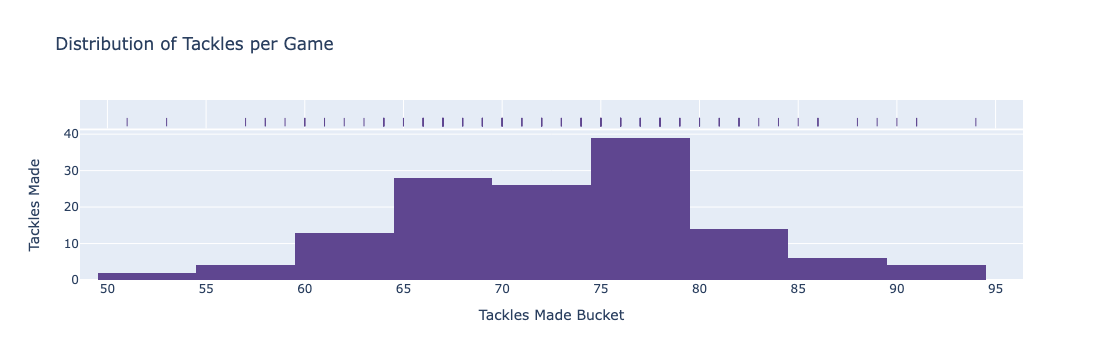

In [171]:
tackle_games = tackles.groupby(['gameId'])['tackle'].agg('sum')

frame = {'game_id': tackle_games.index,
         'tackles': tackle_games}
 
# Creating DataFrame
agg_data = pd.DataFrame(frame).reset_index()
agg_data = agg_data.drop(columns=['game_id'], axis=1)

fig = px.histogram(agg_data, x="tackles", marginal="rug",
                   title='Distribution of Tackles per Game',
                   color_discrete_sequence=px.colors.qualitative.Prism)
# Improve layout
fig.update_layout(
    xaxis_title='Tackles Made Bucket',
    yaxis_title='Tackles Made',
    legend_title='Tackles'
)

fig.show()

The league's distribution of tackles per game skews right, with the highest number of games recording anywhere between `65` and `80` `tackles.

Let's break this down further.

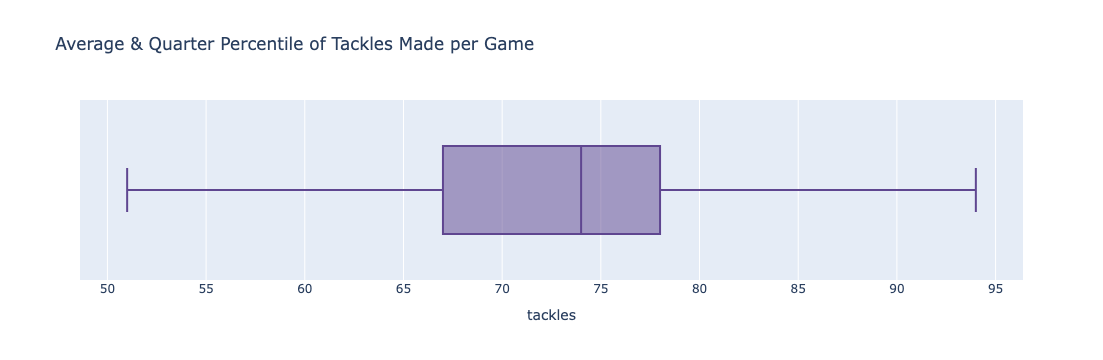

In [172]:
fig = px.box(agg_data, x="tackles",
                   title='Average & Quarter Percentile of Tackles Made per Game',
                   color_discrete_sequence=px.colors.qualitative.Prism)

fig.show()

The median value is `74`, with q1 and q3 being `67` and `78` respectively. We can thus assume that an NFL game, on average, will have 74 total tackles per game.

But what about missed tackles? Find out now!

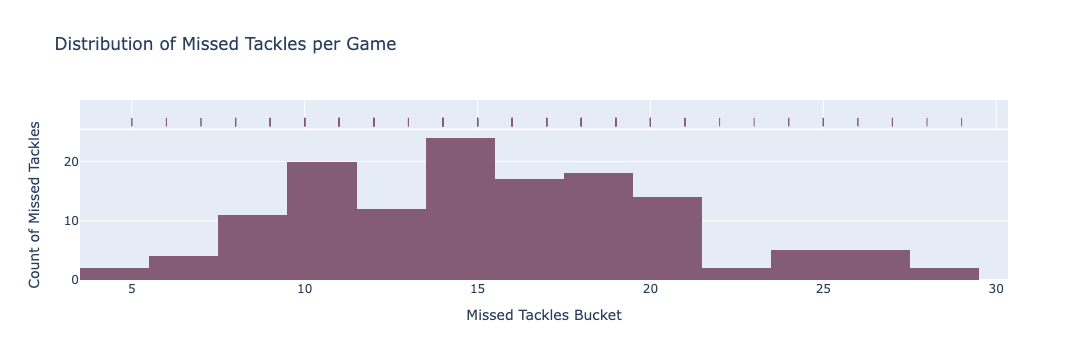

In [166]:
missed_tackles_games = tackles.groupby(['gameId'])['pff_missedTackle'].agg('sum')

frame = {'game_id': missed_tackles_games.index,
         'missed_tackles': missed_tackles_games}
 
# Creating DataFrame by passing Dictionary
agg_data = pd.DataFrame(frame).reset_index()
agg_data = agg_data.drop(columns=['game_id'], axis=1)

fig = px.histogram(agg_data, x="missed_tackles", marginal="rug",
                   title='Distribution of Missed Tackles per Game',
                   color_discrete_sequence=px.colors.qualitative.Antique)

# Improve layout
fig.update_layout(
    xaxis_title='Missed Tackles Bucket',
    yaxis_title='Count of Missed Tackles',
    legend_title='Tackles missed'
)
fig.show()

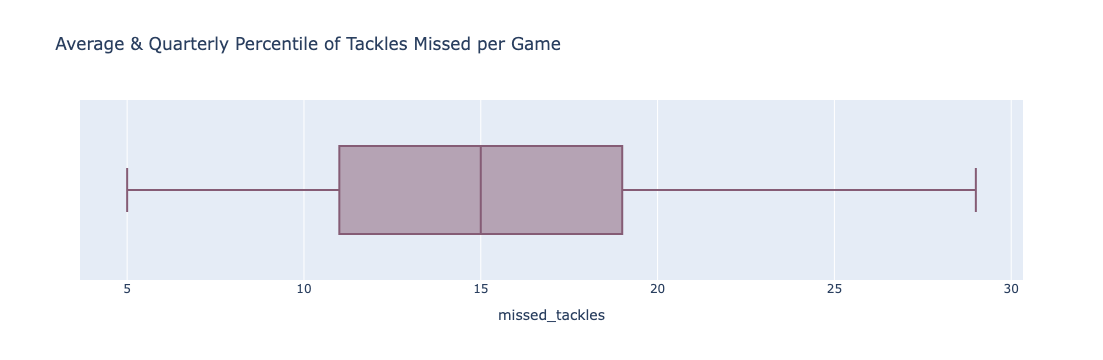

In [127]:
fig = px.box(agg_data, x="missed_tackles",
                   title='Average & Quarterly Percentile of Tackles Missed per Game',
                   color_discrete_sequence=px.colors.qualitative.Antique)
fig.show()

The league's distribution of missed tackles per game generally skews right, with some games featuring outliers. 75% of games saw `19` or fewer missed tackles, with the median being `15`. 

### Player Performance

Now we have taken a look at the league averages, we can start to dive deeper into the four AFC/NFC Championship teams' performance and their players' tackle efficiency.

1. **Tackle Efficiency**: We can calculate tackle efficiency for each player by dividing the total number of tackles by the sum of tackles and missed tackles. This metric will give us an idea of how efficient a player is when they attempt to tackle.
   
   $$ \text{Tackle Efficiency} = \frac{\text{Total Tackles}}{\text{Total Tackles} + \text{Missed Tackles}} $$
   
2. **Forced Fumbles**: While less common than tackles, forced fumbles can easily indicate how much impact a defensive player can have in a game. The more forced fumbles they have, the more likely that player is good at creating turnovers and changing the game..

3. **Assisted Tackles**: This can tell us which players frequently help their teammates in making stops.


In [128]:
# Calculate tackle efficiency for each player
tackles['total_tackles'] = tackles['tackle'] + tackles['assist']
player_performance = tackles.groupby('nflId').agg(
    total_tackles=('total_tackles', 'sum'),
    missed_tackles=('pff_missedTackle', 'sum'),
    forced_fumbles=('forcedFumble', 'sum')
)

# Calculate tackle efficiency
player_performance['tackle_efficiency'] = player_performance['total_tackles'] / (player_performance['total_tackles'] + player_performance['missed_tackles'])

# Merge with player names for better readability
player_performance = player_performance.merge(players[['nflId', 'displayName', 'position']], on='nflId')

# Create a mapping from nflId to club
team_mapping = tracking_1[['nflId', 'club']].drop_duplicates()

# Merge this mapping with the player_performance DataFrame
player_performance = player_performance.merge(team_mapping, on='nflId', how='left')

# Filter players with at least 34 tackles
player_performance_filtered = player_performance[player_performance['total_tackles'] >= 34]

# Filter for players in the final four teams: BAL, DET, SF, KC
final_four_teams = ['BAL', 'DET', 'SF', 'KC']
player_performance_final_four = player_performance_filtered[player_performance_filtered['club'].isin(final_four_teams)]

# Sort players by tackle efficiency in descending order
player_performance_sorted = player_performance_final_four.sort_values(by='tackle_efficiency', ascending=False)

# Display the top 10 players based on tackle efficiency
top_players_final_four = player_performance_sorted.head(10)
top_players_final_four

,nflId,total_tackles,missed_tackles,forced_fumbles,tackle_efficiency,displayName,position,club
368,46757,34,0,1,1.000000,Charvarius Ward,CB,SF
484,52411,46,1,1,0.978723,Jeff Okudah,CB,DET
605,53487,69,2,0,0.971831,Nick Bolton,ILB,KC
296,46139,54,3,0,0.947368,Fred Warner,ILB,SF
227,44888,61,4,0,0.938462,Alex Anzalone,ILB,DET
332,46259,51,4,0,0.927273,DeShon Elliott,FS,DET
430,47931,48,4,0,0.923077,Dre Greenlaw,ILB,SF
250,44999,54,6,1,0.900000,Chuck Clark,SS,BAL
538,52546,54,6,1,0.900000,L'Jarius Sneed,CB,KC
758,54653,43,6,0,0.877551,Malcolm Rodriguez,ILB,DET


[On average, Defensive Backs make 2.15 tackles per game](https://www.statmuse.com/nfl/ask/average-tackles-per-game-by-cornerbacks-2021). Assuming the average player plays all 17 games in their NFL season (including the bye week), they'd make approximately 34 total tackles. I thus filtered the results to 34 or more total tackles.

### Team Performance:

1. **Total Tackles by Team**: We'll aggregate the total number of tackles made by players of each team to get a sense of which teams are the best at stopping their opponents.
2. **Total Missed Tackles by Team**: We'll also aggregate the missed tackles to determine which teams might need to improve their tackling.
3. **Win Rate**: Using the `games.csv` data, we'll calculate the win rate for each team over the season.

Let's start by calculating the total tackles and missed tackles for each team. Since the `tackles.csv` file doesn't directly contain the team of each player, we'll first join it with the `plays.csv` data to get the defensive team for each play, and then aggregate the metrics.


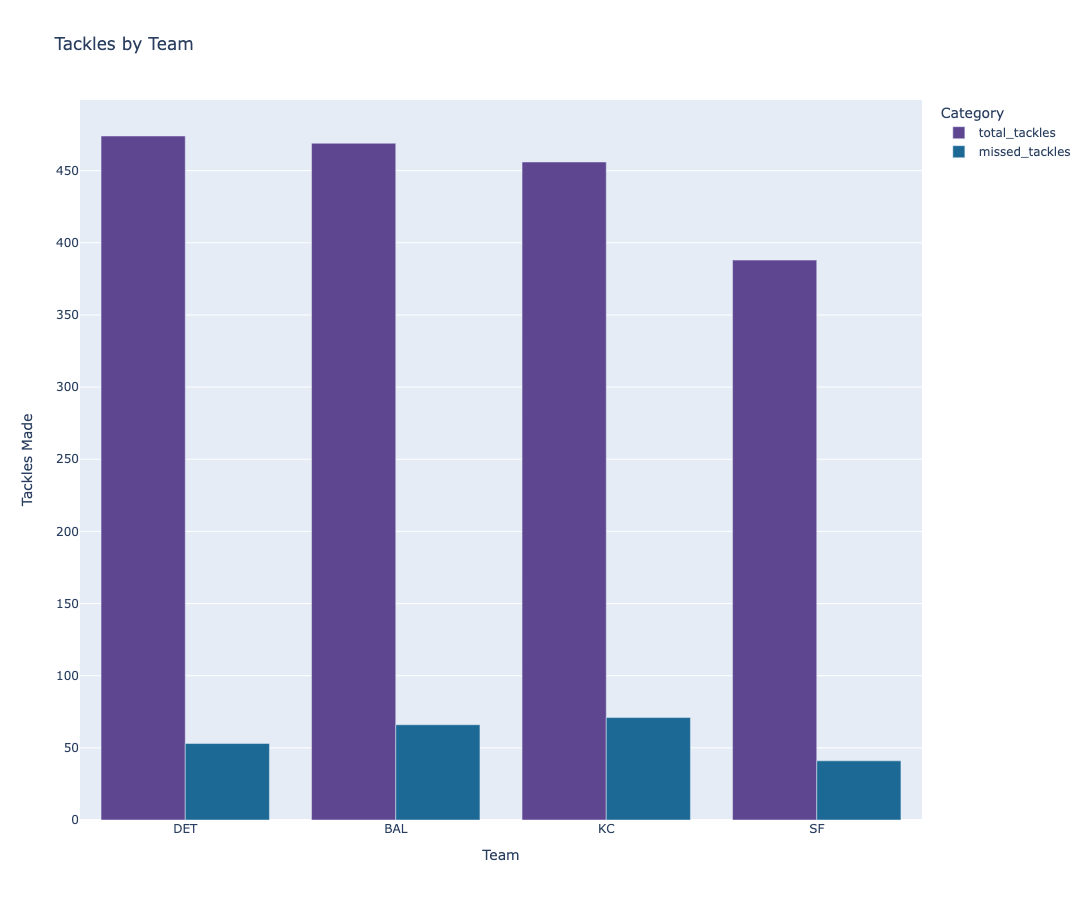

In [165]:
# Merge tackles data with plays data to get the defensive team for each play
team_tackles_df = tackles.merge(plays[['gameId', 'playId', 'defensiveTeam']], on=['gameId', 'playId'])

# Calculate total tackles and missed tackles for each team
team_performance = team_tackles_df.groupby('defensiveTeam').agg(
    total_tackles=('total_tackles', 'sum'),
    total_assists=('assist', 'sum'),
    total_forced_fumbles=('forcedFumble','sum'),
    missed_tackles=('pff_missedTackle', 'sum')
).reset_index()

# Calculate total assists + tackles
team_performance['total_tackles_and_assists'] = team_performance['total_tackles'] + team_performance['total_assists']

# Calculate tackle efficiency
team_performance['tackle_efficiency'] = team_performance['total_tackles'] / (team_performance['total_tackles'] + team_performance['missed_tackles'])

# Filter to just display the final four teams
filtered_teams = ['BAL', 'DET', 'SF', 'KC']
team_performance_filtered = team_performance[team_performance['defensiveTeam'].isin(filtered_teams)]

# Sort teams by total tackles in descending order
team_performance_sorted = team_performance_filtered.sort_values(by='total_tackles', ascending=False)


# Melt DataFrame to long format
team_performance_long = pd.melt(team_performance_sorted, id_vars='defensiveTeam', value_vars=['total_tackles', 'missed_tackles'],
                                var_name='Category', value_name='Value')
# Order the list by tackles
ordered_teams = team_performance_sorted['defensiveTeam'].unique()

# Map the defensive teams to an order using Categorical data type
team_performance_long['defensiveTeam'] = pd.Categorical(team_performance_long['defensiveTeam'], categories=ordered_teams, ordered=True)

# Sort the DataFrame by 'defensiveTeam' according to the order defined above
team_performance_long = team_performance_long.sort_values('defensiveTeam')

# Plot the long DataFrame
fig = px.bar(
    team_performance_long,
    x='defensiveTeam',
    y='Value', 
    color='Category', 
    barmode='group',  
    title='Tackles by Team',
    height=900,
    width=800,
    orientation='v',
    color_discrete_sequence=px.colors.qualitative.Prism,
)
# Improve layout
fig.update_layout(
    xaxis_title='Team',
    yaxis_title='Tackles Made',
)

fig.show()



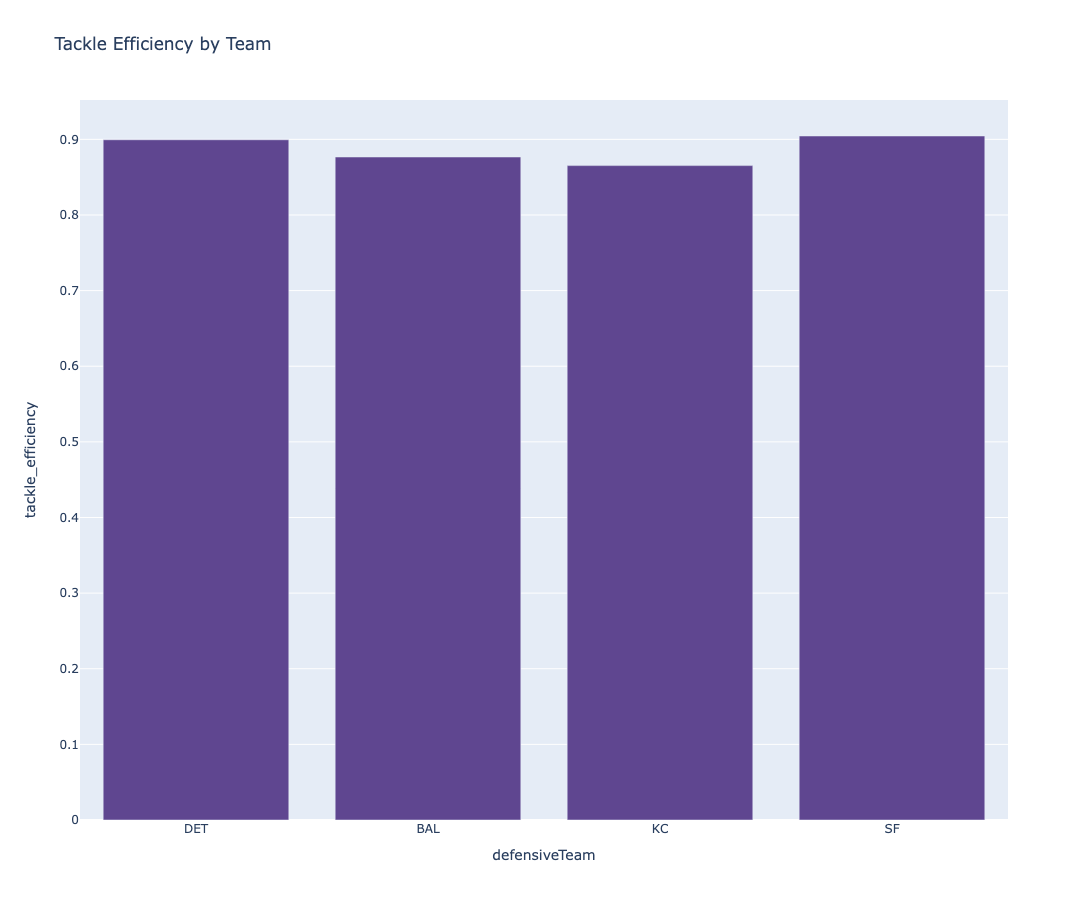

In [135]:
fig = px.bar(
    team_performance_sorted,
    y='tackle_efficiency', 
    x="defensiveTeam", 
    orientation='v', 
    title='Tackle Efficiency by Team', 
    height=900, 
    width=800,
    color_discrete_sequence=px.colors.qualitative.Prism,
)
fig.show()


Of the four teams heading to the AFC/NFC Championships, the San Francisco 49ers boasted the highest tackle efficiency in 2022 with a 90.44% efficiency average. Interestingly, the Niners made the least amount of total tackles but also made the least amount of missed tackles. The 49ers also have the player who had the highest tackle efficiency of those who reached the 34 tackles per season average in Chavarius Ward.

To continue understanding the impact that defensive record has had on results, let's calculate the win rate for each team using the games.csv data. The win rate is the ratio of games won to total games played.

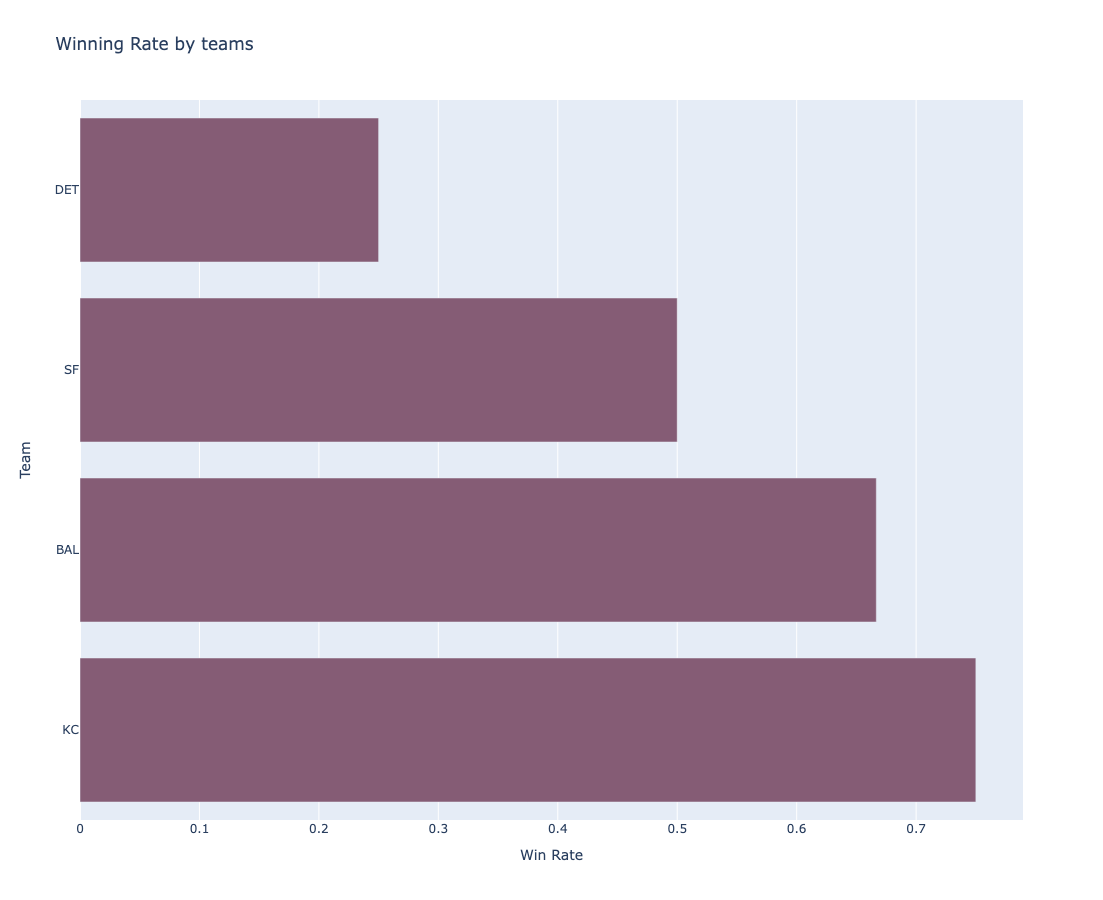

In [164]:
# Calculate win counts for home and visitor teams
home_wins = games[games['homeFinalScore'] > games['visitorFinalScore']].groupby('homeTeamAbbr').size().reset_index(name='home_wins')
visitor_wins = games[games['visitorFinalScore'] > games['homeFinalScore']].groupby('visitorTeamAbbr').size().reset_index(name='visitor_wins')

# Merge win counts and calculate total wins for each team
team_wins = home_wins.merge(visitor_wins, left_on='homeTeamAbbr', right_on='visitorTeamAbbr', how='outer').fillna(0)
team_wins['total_wins'] = team_wins['home_wins'] + team_wins['visitor_wins']

# Calculate total games played by each team
total_games_played = games.groupby('homeTeamAbbr').size().reset_index(name='games_played')

# Calculate the total number of games played by each team
team_games_home = games['homeTeamAbbr'].value_counts()
team_games_visitor = games['visitorTeamAbbr'].value_counts()
total_games_per_team = team_games_home.add(team_games_visitor, fill_value=0)

# Merge win counts with total games played to calculate win rate
team_win_rate = team_wins.merge(total_games_played, left_on='homeTeamAbbr', right_on='homeTeamAbbr')

# Calculate win rate using the correct total games played
team_win_rate['games_played'] = team_win_rate['homeTeamAbbr'].map(total_games_per_team)
team_win_rate['win_rate'] = team_win_rate['total_wins'] / team_win_rate['games_played']

# Filter to just display the final four teams: BAL, DET, SF, KC
final_four_teams = ['BAL', 'DET', 'SF', 'KC']
team_win_rate_filtered = team_win_rate[team_win_rate['homeTeamAbbr'].isin(final_four_teams)]

# Sort teams by win rate in descending order
team_win_rate_sorted = team_win_rate_filtered[['homeTeamAbbr', 'win_rate']].sort_values(by='win_rate', ascending=False)

fig = px.bar(
    team_win_rate_sorted, 
    y='homeTeamAbbr', 
    x="win_rate", 
    orientation='h', 
    title='Winning Rate by teams', 
    height=900, 
    width=800,
    color_discrete_sequence=px.colors.qualitative.Antique,
)
# Improve layout
fig.update_layout(
    xaxis_title='Win Rate',
    yaxis_title='Team',
    legend_title='Winning %'
)

fig.show()

In 2022, Kansas City Chiefs (KC) have the highest win rate of 75%. This indicates they had enjoyed a 6-2 record last season, despite having the lowest tackle efficiency % of 86.5%. In contrast, the Detroit Lions (DET) had the lowest win rate of 25% during the first 9 games of last season despite having the highest total tackles.

So does tackling performance help or hinder win_rate as much as others think? Let's see the correlations that may impact winning (and losing).

<Axes: >

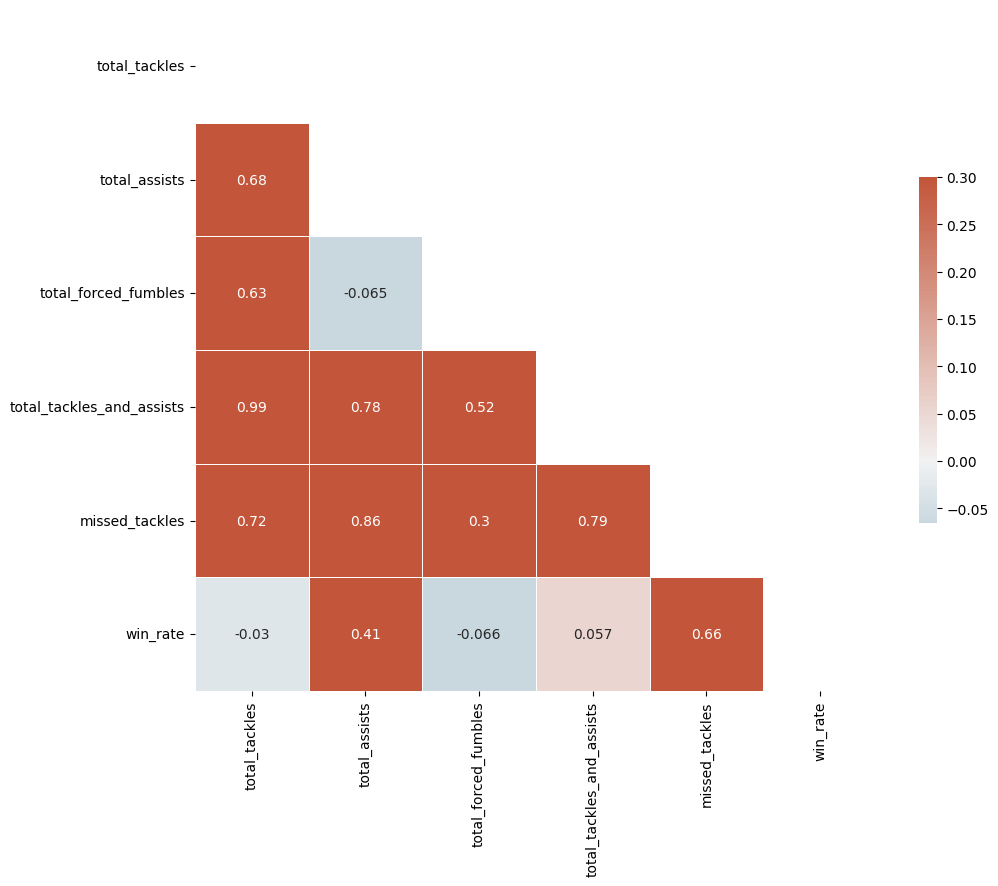

In [137]:
# Merge tackles data with plays data to get the defensive team for each play
team_tackles_df = tackles.merge(plays[['gameId', 'playId', 'defensiveTeam']], on=['gameId', 'playId'])

# Calculate total tackles and missed tackles for each team
team_performance = team_tackles_df.groupby('defensiveTeam').agg(
    total_tackles=('total_tackles', 'sum'),
    total_assists=('assist', 'sum'),
    total_forced_fumbles=('forcedFumble','sum'),
    missed_tackles=('pff_missedTackle', 'sum')
).reset_index()

# Calculate total assists + tackles
team_performance['total_tackles_and_assists'] = team_performance['total_tackles'] + team_performance['total_assists']


dd = team_performance_sorted.merge(team_win_rate[['homeTeamAbbr', 'win_rate']], 
                                   left_on='defensiveTeam', 
                                   right_on='homeTeamAbbr')

d = dd[['total_tackles', 'total_assists', 'total_forced_fumbles', 'total_tackles_and_assists', 'missed_tackles',  'win_rate']]

# Compute the correlation matrix for numeric features
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

As we can see above, forced fumbles and total tackles have little to no correlation to the win rate for the teams heading to the AFC/NFC Championship games. However, missed tackles have a strong-level correlation with win rate (`0.66`). That one missed tackle that leads to a running back going all the way can make the difference between going to Las Vegas and going home.

## Clutch Time, Show Time:

In the NFL postseason, every game is "win or go home". With no second chances, the four remaining teams must make the most of their opportunities on Defense. Now we know that missed tackles make an impact on winning, we're going to look into how teams perform in Q4 and how different play types and schemes can create varying levels of tackling success. 

Let's start by analyzing the play type distribution and clock management style for each team. We'll categorize the plays based on common keywords in the `playDescription` column.

In [138]:
# Function to categorize play type based on play description
def categorize_play_type(description):
    if "pass" in description.lower():
        return "Pass"
    elif "run" in description.lower():
        return "Run"
    elif "kick" in description.lower() or "punt" in description.lower():
        return "Kick/Punt"
    elif "field goal" in description.lower():
        return "Field Goal"
    else:
        return "Other"

# Define the list of the final four teams
final_four_teams = ['BAL', 'DET', 'SF', 'KC']

# Apply the function to the plays data
plays['playType'] = plays['playDescription'].apply(categorize_play_type)

# Calculate play type distribution for each team
play_type_distribution = plays.groupby(['possessionTeam', 'playType']).size().unstack().fillna(0)

# Calculate percentage distribution
play_type_distribution_percentage = play_type_distribution.divide(play_type_distribution.sum(axis=1), axis=0) * 100

# Filter for the final four teams
play_type_distribution_final_four = play_type_distribution_percentage.loc[final_four_teams]

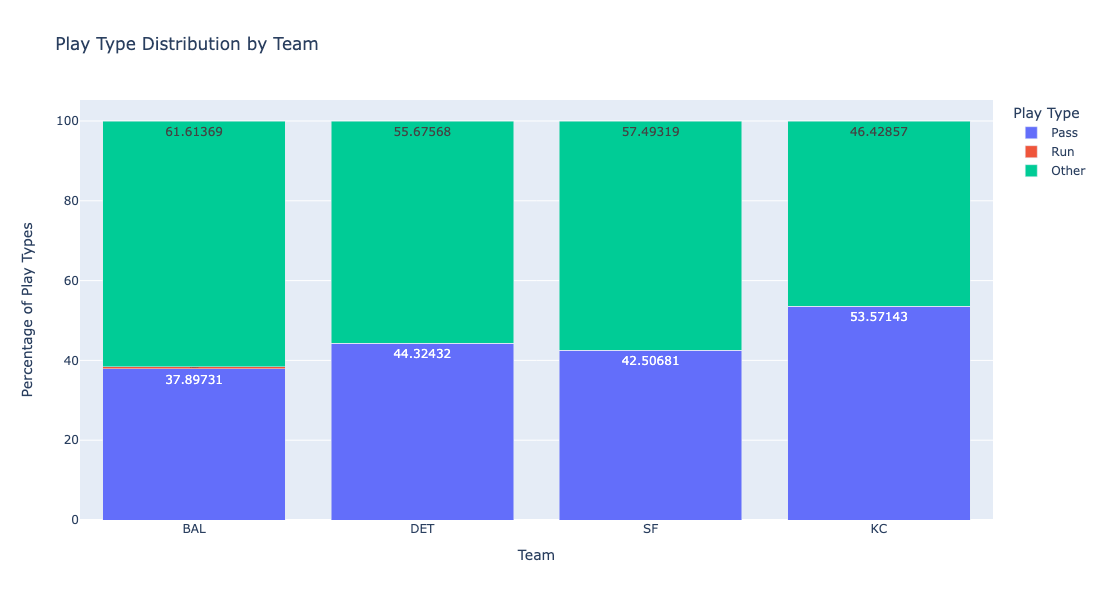

In [139]:
# Prepare for chart creation
play_type_distribution_final_four_reset = play_type_distribution_final_four.reset_index()

# Melt the DataFrame to long format for barcharts
play_type_distribution_long = play_type_distribution_final_four_reset.melt(id_vars='possessionTeam', var_name='Play Type', value_name='Percentage')

# Create a stacked bar chart
fig = px.bar(
    play_type_distribution_long,
    x='possessionTeam',
    y='Percentage',
    color='Play Type',
    title='Play Type Distribution by Team',
    text_auto=True,  
    labels={"possessionTeam": "Possession Team"},
    category_orders={"Play Type": ["Pass", "Run", "Other", "Kick/Punt", "Field Goal"]},
    height=600,
    width=800
)

# Improve layout
fig.update_layout(
    barmode='stack', 
    xaxis_title='Team',
    yaxis_title='Percentage of Play Types',
    legend_title='Play Type'
)

fig.show()

From the chart, we can infer that:

* All four teams use special plays that do not explicitly fall into "pass" or "run". These  plays are likely unique to each team and thus fall into "Other" since they are bespoke.
* Detroit, San Francisco, and Kansas City do not use classic "Run" plays whatsoever. Baltimore was the only team to use "Run" plays, but even then they seldom did so (0.49%).
* Kansas City is most likely to pass the ball (53.57%), where as Baltimore is least likely to pass the ball (37.9%).

Let's analyze how these four manage the clock, specifically on whether often they call passing plays by the quarter:

In [140]:
# Play type distribution for each team based on the quarter
play_type_by_quarter = plays.groupby(['possessionTeam', 'quarter', 'playType']).size().unstack().fillna(0)

# Calculate percentage distribution
play_type_by_quarter_percentage = play_type_by_quarter.divide(play_type_by_quarter.sum(axis=1), axis=0) * 100

# Prepare for filtering
play_type_by_quarter_percentage_reset = play_type_by_quarter_percentage.reset_index()

# Filter for the final four teams: BAL, DET, SF, KC
final_four_teams = ['BAL', 'DET', 'SF', 'KC']
play_type_by_quarter_final_four = play_type_by_quarter_percentage_reset[play_type_by_quarter_percentage_reset['possessionTeam'].isin(final_four_teams)]

# 'Pass' play percentage by quarter for each team
play_type_by_quarter_final_four_pass = play_type_by_quarter_final_four.pivot(index='possessionTeam', columns='quarter', values='Pass').fillna(0)


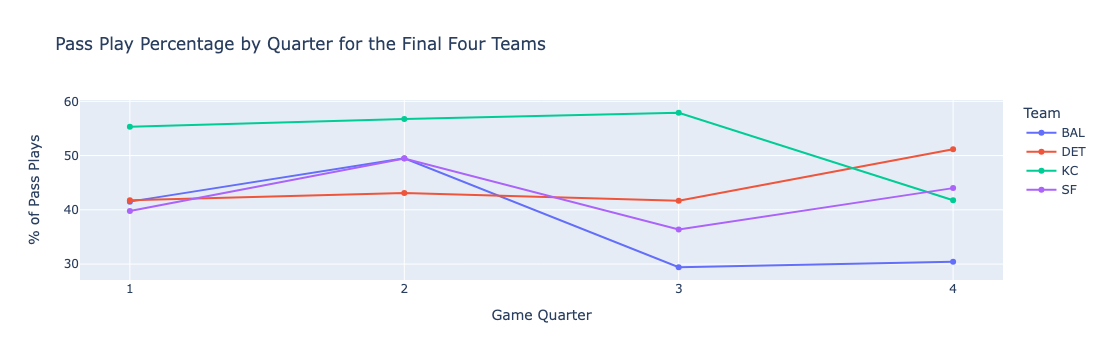

In [141]:
# Prep for charts
play_type_by_quarter_final_four_pass = play_type_by_quarter_final_four_pass.reset_index()

# Melt the DataFrame
play_type_long = play_type_by_quarter_final_four_pass.melt(id_vars='possessionTeam', value_vars=[1, 2, 3, 4], var_name='Quarter', value_name='Pass Percentage')

# Create the line chart
fig = px.line(
    play_type_long,
    x='Quarter',
    y='Pass Percentage',
    color='possessionTeam',
    markers=True,  
    title='Pass Play Percentage by Quarter for the Final Four Teams',
    labels={
        'possessionTeam': 'Team',
        'Quarter': 'Game Quarter',
        'Pass Percentage': '% of Pass Plays'
    }
)

# Improve layout
fig.update_layout(
    xaxis_title='Game Quarter',
    yaxis_title='% of Pass Plays',
    legend_title='Team',
    xaxis=dict(type='category')
)

fig.show()

From the chart above, we can observe some interesting patterns:

AFC:
* Kansas City tends to pass more than 50% of the time from the 1st to 3rd Quarters. They switch to other plays by the 4th quarter, likely to run down the clock if they are winning.
* Baltimore passes most in the 2nd Quarter. However, by the 3rd quarter, their passing plays never make up more than 30% of total plays.

NFC:
*  Detroit, in contrast to Kansas City, prefers to pass less often in the first three quarters. However, the Lions switch to passing by the 4th Quarter, the only quarter when they exceed 50% in passing plays.
* San Francisco tends to utilize special plays or non-conventional running in the 1st and 3rd quarters. For the even numbered quarters (2nd and 4th), they switch to more passing plays.


### Tackles & Misses by Play
With a better understanding of the teams' offensive style, it is now time to see how many tackles and misses occur in the 4th Quarter across the league, as well as the strategies that may impact this.

We're going to first pre-process our data.

In [142]:
agg_dict_1 = {
    "tackles": pd.NamedAgg(column='tackle', aggfunc='sum'),
    "assists": pd.NamedAgg(column='assist', aggfunc='sum'),
    "forced_fumbles": pd.NamedAgg(column='forcedFumble', aggfunc='sum'),
    "missed_tackles": pd.NamedAgg(column='pff_missedTackle', aggfunc='sum'),
}

play_tackle_df = tackles.groupby(["gameId", "playId"]).agg(**agg_dict_1).reset_index()


play_tackles = pd.merge(
    plays,
    play_tackle_df,
    how="outer",
    on=["gameId", "playId"]
)

play_tackles.head()

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,playType,tackles,assists,forced_fumbles,missed_tackles
0,2022100908,3537,48723,Parker Hesse,(7:52) (Shotgun) M.Mariota pass short middle t...,4,1,10,ATL,TB,...,0.981955,NaN,NaN,NaN,NaN,Pass,1.0,0.0,0.0,0.0
1,2022091103,3126,52457,Chase Claypool,(7:38) (Shotgun) C.Claypool right end to PIT 3...,4,1,10,PIT,CIN,...,-0.263424,NaN,NaN,NaN,NaN,Other,1.0,0.0,0.0,1.0
2,2022091111,1148,42547,Darren Waller,(8:57) D.Carr pass short middle to D.Waller to...,2,2,5,LV,LAC,...,1.133666,NaN,NaN,NaN,NaN,Pass,1.0,0.0,0.0,0.0
3,2022100212,2007,46461,Mike Boone,(13:12) M.Boone left tackle to DEN 44 for 7 ya...,3,2,10,DEN,LV,...,-0.043580,NaN,NaN,NaN,NaN,Other,0.0,2.0,0.0,2.0
4,2022091900,1372,47857,Devin Singletary,(8:33) D.Singletary right guard to TEN 32 for ...,2,1,10,BUF,TEN,...,-0.167903,NaN,NaN,NaN,NaN,Other,0.0,2.0,0.0,1.0


To prevent non-tackle events from disrupting our analysis, let's use `-1` to fill out any nulls.

In [143]:
values = {"tackles": -1.0, "assists": -1.0, "forced_fumbles": -1.0, "missed_tackles": -1.0}
play_tackles = play_tackles.fillna(value=values)

play_tackles = play_tackles.astype({"tackles":'int', "assists":'int', 
                                    "forced_fumbles":'int', "missed_tackles":'int',}) 

play_tackles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12486 entries, 0 to 12485
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   gameId                            12486 non-null  int64  
 1   playId                            12486 non-null  int64  
 2   ballCarrierId                     12486 non-null  int64  
 3   ballCarrierDisplayName            12486 non-null  object 
 4   playDescription                   12486 non-null  object 
 5   quarter                           12486 non-null  int64  
 6   down                              12486 non-null  int64  
 7   yardsToGo                         12486 non-null  int64  
 8   possessionTeam                    12486 non-null  object 
 9   defensiveTeam                     12486 non-null  object 
 10  yardlineSide                      12319 non-null  object 
 11  yardlineNumber                    12486 non-null  int64  
 12  game

With the data further cleaned, we can look into the successful (and unsuccessful) tackles made in the fourth quarter.

Finally, we can look into Time Management to see how teams adapt their strategies as the game progresses. Specifically, we can analyze the play type distribution by quarter. 

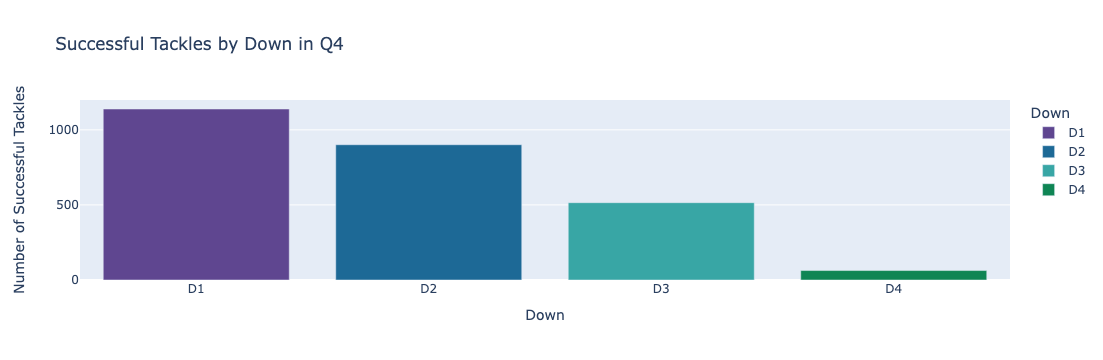

In [155]:
# Filter for only Q4 data
agg_data_q4 = agg_data[agg_data['quarter'] == "Q4"]

successful_tackle_plays = play_tackles[play_tackles['tackles'] > 0]

agg_data = successful_tackle_plays[["quarter", "down"]].groupby(["quarter", "down"]).size().reset_index(name="count")

di =  {1: "Q1", 2: "Q2", 3: "Q3", 4: "Q4", 5: "Q5"}
agg_data['quarter'] = agg_data['quarter'].map(di) 

di =  {1: "D1", 2: "D2", 3: "D3", 4: "D4"}
agg_data['down'] = agg_data['down'].map(di) 

# Create a bar chart for Q4 successful tackles by down
fig = px.bar(
    agg_data_q4,
    x='down',
    y='count',
    title='Successful Tackles by Down in Q4',
    color='down',
    labels={'count': 'Number of Successful Tackles', 'down': 'Down'},
    color_discrete_sequence=px.colors.qualitative.Prism,
)

# Improve layout
fig.update_layout(
    xaxis_title='Down',
    yaxis_title='Number of Successful Tackles',
    legend_title='Down'
)
# display the figure
fig.show()


From the above, we can observe:

* Most tackles made in the fourth quarter will be made in the 1st down (`1,139`).
* 3rd Downs see the fewest tackles made of the three downs an offensive unit is usually on the field (`515`) 
* In the rare play made in the 4th quarter, `63` of them end in successful tackles.

Let's now see the missed tackles:

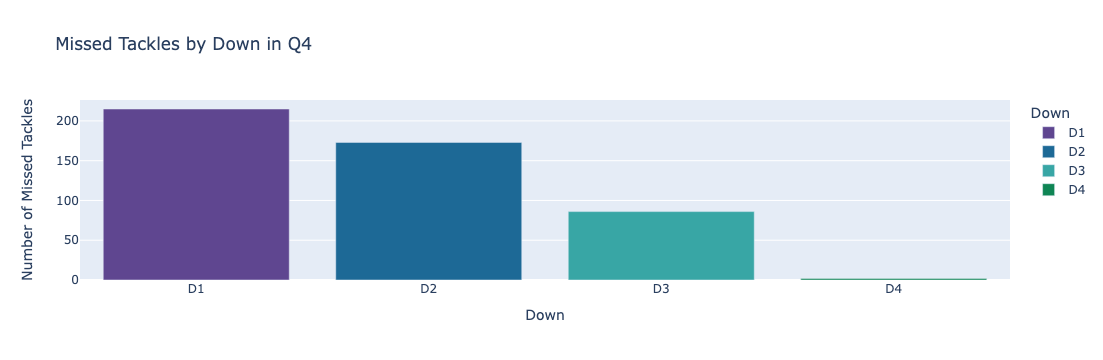

In [159]:
# Filter for only Q4 data
agg_data_q4 = agg_data[agg_data['quarter'] == "Q4"]

missed_tackle_plays = play_tackles[play_tackles['missed_tackles'] > 0]

agg_data = missed_tackle_plays[["quarter", "down"]].groupby(["quarter", "down"]).size().reset_index(name="count")

di =  {1: "Q1", 2: "Q2", 3: "Q3", 4: "Q4", 5: "Q5"}
agg_data['quarter'] = agg_data['quarter'].map(di) 

di =  {1: "D1", 2: "D2", 3: "D3", 4: "D4"}
agg_data['down'] = agg_data['down'].map(di) 

# Create a bar chart for Q4 successful tackles by down
fig = px.bar(
    agg_data_q4,
    x='down',
    y='count',
    title='Missed Tackles by Down in Q4',
    color='down',
    labels={'count': 'Number of Missed Tackles', 'down': 'Down'},
    color_discrete_sequence=px.colors.qualitative.Prism,
)

# Improve layout
fig.update_layout(
    xaxis_title='Down',
    yaxis_title='Number of Missed Tackles',
    legend_title='Down'
)
# display the figure
fig.show()


From the above, we can observe:

* Most missed tackles are likely to occur in the 1st down `215` 
* 3rd Downs see the fewest missed tackles of the three downs an offensive unit is usually on the field (`86`) 
* In the 4th quarter, `2` of them saw defensive players miss their tackles.

### Team Tackle Success Ratios

How can these teams exploit their opponents' defense and create more opportunities for missed tackles? Let's see the formations used accompanied by a successful tackle % rate. We'll start with the league average:

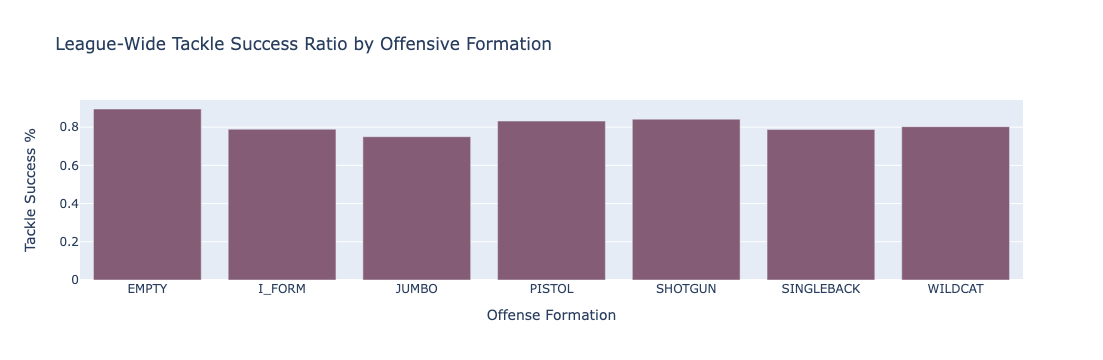

In [184]:
ctt = pd.crosstab(play_tackles['offenseFormation'], play_tackles['tackles'])
ctt.columns = ['No tackles', 
                'Unsuccessful tackles',
               'Successful tackles',
               '2 successful tackles']

ctt['success_ratio'] = round( (ctt['Successful tackles'] / (ctt['Successful tackles'] + ctt['Unsuccessful tackles']) ), 4)

fig = px.bar(ctt, x=ctt.index, y="success_ratio",
                   title='League-Wide Tackle Success Ratio by Offensive Formation',
                   color_discrete_sequence=px.colors.qualitative.Antique)

# Improve layout
fig.update_layout(
    xaxis_title='Offense Formation',
    yaxis_title='Tackle Success %',
    legend_title='Tackle Success Percentage'
)
fig.show()

As we can see above
* `Jumbo` formations have the lowest successful tackle rate. 25% of tackles miss against offenses playing with this formation.
* `Singleback` and `I-Form` also prove difficult for defenses. Both formation types saw 21% or higher in unsuccessful tackles. 

### Team Tackle Success Ratios

Now we can look into the performance of each team's defense. Let's start with the AFC Championship teams:

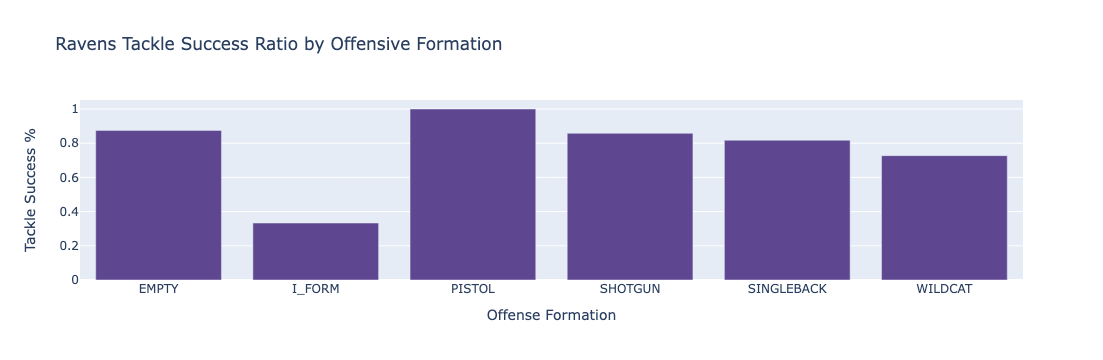

In [190]:
# Filter for BAL as the defensive team
det_tackles = play_tackles[play_tackles['defensiveTeam'] == 'BAL']

ctt = pd.crosstab(det_tackles['offenseFormation'], det_tackles['tackles'])

tackle_columns = [f"{i} tackles" for i in ctt.columns]
ctt.columns = tackle_columns

#  '1 tackle' is considered successful and '0 tackles' is unsuccessful.
if '1 tackles' in ctt.columns and '0 tackles' in ctt.columns:
    ctt['success_ratio'] = round((ctt['1 tackles'] / (ctt['1 tackles'] + ctt['0 tackles'])), 4)
else:
    ctt['success_ratio'] = 0  # Adjust this logic based on your specific definition of success


# Create the bar chart with updated success_ratio calculation
fig = px.bar(ctt, x=ctt.index, y="success_ratio",
             title='Ravens Tackle Success Ratio by Offensive Formation',
             color_discrete_sequence=px.colors.qualitative.Prism)

# Improve layout
fig.update_layout(
    xaxis_title='Offense Formation',
    yaxis_title='Tackle Success %',
    legend_title='Tackle Success Percentage'
)

# Display the figure
fig.show()


As we can see from the chart above:
* The Ravens' defense is best suited against the `Pistol` formation. All tackles made against offenses running in the `Pistol` formation have been successful. They also saw 85% or higher success against the `Empty` and `Shotgun` formations.
* Their weakness is the `I-Form` formation. They have a successful tackle ratio of just 33.3% against `I-Form` defenses. `Wildcat` is also potentially a hole for the Ravens, as they have a success ratio of 72.7% against `Wildcat` formations.




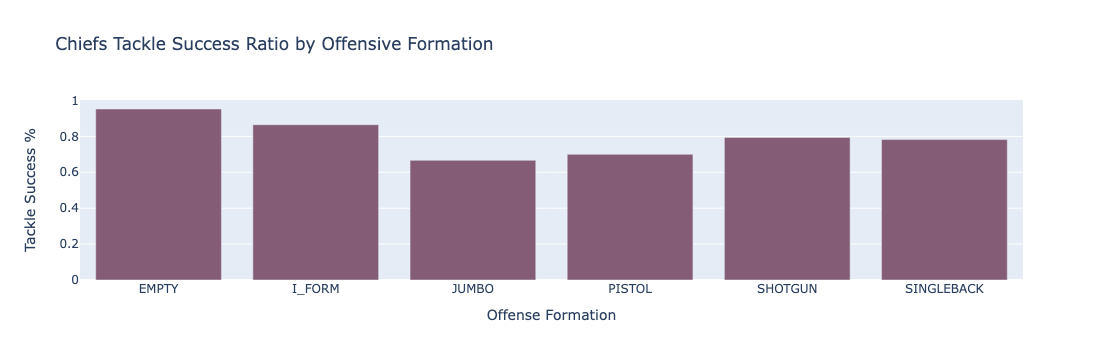

In [191]:
# Filter for KC as the defensive team
det_tackles = play_tackles[play_tackles['defensiveTeam'] == 'KC']

ctt = pd.crosstab(det_tackles['offenseFormation'], det_tackles['tackles'])

tackle_columns = [f"{i} tackles" for i in ctt.columns]
ctt.columns = tackle_columns

#  '1 tackle' is considered successful and '0 tackles' is unsuccessful.
if '1 tackles' in ctt.columns and '0 tackles' in ctt.columns:
    ctt['success_ratio'] = round((ctt['1 tackles'] / (ctt['1 tackles'] + ctt['0 tackles'])), 4)
else:
    ctt['success_ratio'] = 0  # Adjust this logic based on your specific definition of success


# Create the bar chart with updated success_ratio calculation
fig = px.bar(ctt, x=ctt.index, y="success_ratio",
             title='Chiefs Tackle Success Ratio by Offensive Formation',
             color_discrete_sequence=px.colors.qualitative.Antique)

# Improve layout
fig.update_layout(
    xaxis_title='Offense Formation',
    yaxis_title='Tackle Success %',
    legend_title='Tackle Success Percentage'
)

# Display the figure
fig.show()


As we can see from the chart above:
* The Chiefs' defense is best suited against the `Empty` formation. `Empty` formation offensive plays ended in a successful tackle ratio of 95.2%. They also saw 85% or higher success against the `I-Form` formations.
* The Chiefs are most vulnerable against `Jumbo` formations. They have a successful tackle ratio of 66.7% against `Jumbo` offensive plays. `Pistol` is also an area of improvement for the Chiefs, as they have a success ratio of 70% against `Pistol` formations.


Let's now turn our attention to the NFC Championship teams:

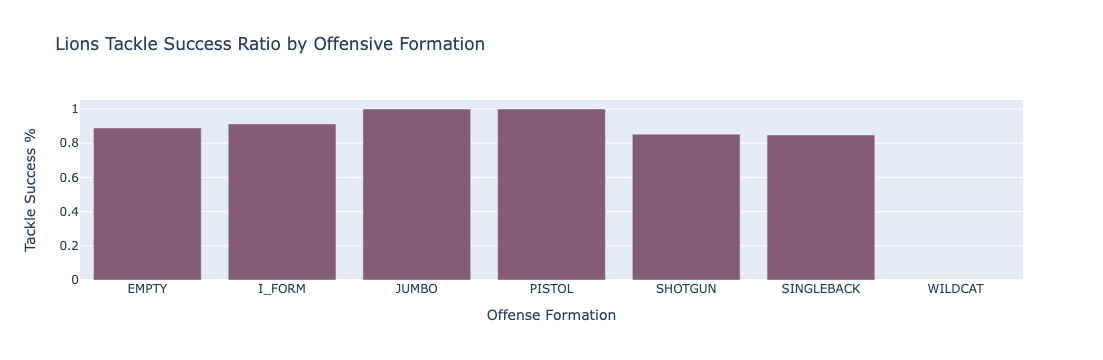

In [187]:
# Filter for DET as the defensive team
det_tackles = play_tackles[play_tackles['defensiveTeam'] == 'DET']

ctt = pd.crosstab(det_tackles['offenseFormation'], det_tackles['tackles'])

tackle_columns = [f"{i} tackles" for i in ctt.columns]
ctt.columns = tackle_columns

#  '1 tackle' is considered successful and '0 tackles' is unsuccessful.
if '1 tackles' in ctt.columns and '0 tackles' in ctt.columns:
    ctt['success_ratio'] = round((ctt['1 tackles'] / (ctt['1 tackles'] + ctt['0 tackles'])), 4)
else:
    ctt['success_ratio'] = 0  # Adjust this logic based on your specific definition of success


# Create the bar chart with updated success_ratio calculation
fig = px.bar(ctt, x=ctt.index, y="success_ratio",
             title='Lions Tackle Success Ratio by Offensive Formation',
             color_discrete_sequence=px.colors.qualitative.Antique)

# Improve layout
fig.update_layout(
    xaxis_title='Offense Formation',
    yaxis_title='Tackle Success %',
    legend_title='Tackle Success Percentage'
)

# Display the figure
fig.show()


As we can see from the chart above:
* The Lions' defense is best suited against the `Jumbo` and `Pistol` formations. Both formations saw their offensive plays end in the Lions achieving a perfect successful tackle ratio. They also 90% or higher success against the `I-Form` formation.
* The Lions are least likely to make a tackle against `Singleback` formations. Their successful tackle ratio against `Singleback` plays is 84.,8%, the lowest of the formations with a registered successful tackle. `Wildcat` had also yet to see a successful tackle from the Lions as of Week 9 in 2022, and it may be an area where their opponents can see an opportunity.


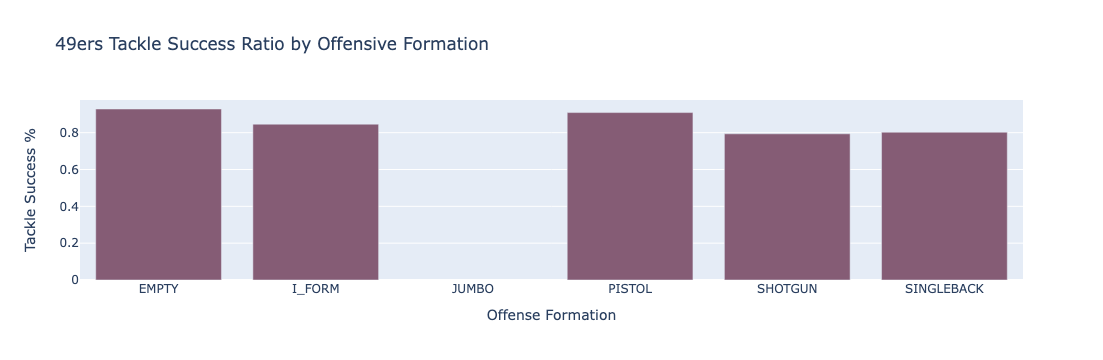

In [188]:
# Filter for SF as the defensive team
det_tackles = play_tackles[play_tackles['defensiveTeam'] == 'SF']

ctt = pd.crosstab(det_tackles['offenseFormation'], det_tackles['tackles'])

tackle_columns = [f"{i} tackles" for i in ctt.columns]
ctt.columns = tackle_columns

#  '1 tackle' is considered successful and '0 tackles' is unsuccessful.
if '1 tackles' in ctt.columns and '0 tackles' in ctt.columns:
    ctt['success_ratio'] = round((ctt['1 tackles'] / (ctt['1 tackles'] + ctt['0 tackles'])), 4)
else:
    ctt['success_ratio'] = 0  # Adjust this logic based on your specific definition of success


# Create the bar chart with updated success_ratio calculation
fig = px.bar(ctt, x=ctt.index, y="success_ratio",
             title='49ers Tackle Success Ratio by Offensive Formation',
             color_discrete_sequence=px.colors.qualitative.Antique)

# Improve layout
fig.update_layout(
    xaxis_title='Offense Formation',
    yaxis_title='Tackle Success %',
    legend_title='Tackle Success Percentage'
)

# Display the figure
fig.show()


As we can see from the chart above:
* The 49ers' defense is most locked in against `Empty` and `Pistol` formations. `Empty` formations see the 49ers successfully tackle 92.9% of the time. `Pistol`, meanwhile, sees the 49ers make a successful tackle 90.9% of the time..
* The 49ers are most vulnerable against `Shotgun` formations. Their successful tackle ratio against `Shotgun` plays is the only category with a registered successful tackle that is below 80%, so the Lions may use more Shotgun offenses against the 49ers. They also had yet to record a successful tackle against `Jumbo` formations as of Week 9 in 2022. 

### In Part II, we will conduct additional analysis and make final predictions ahead of Super Bowl LVII. Stay tuned!